# Ejemplo de Inferencia

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! pip install ultralytics

In [14]:
import os
import shutil
import json
from ultralytics import YOLO

## Ajustes Iniciales

In [16]:
student_name = "arevalo_ezequiel"

model_path = "../augmentation/computer-vision/runs/detect/train9/weights/best.pt"

imgs_dir = "data/eval/images/val"
base_dir = "data/out"
# imgs_dir = "/content/drive/MyDrive/TUIA/CV/2024-01_practico/data/eval/images/val"
# base_dir = "/content/drive/MyDrive/TUIA/CV/2024-01_practico/data/out"

dets_dir = os.path.join(base_dir, student_name)

In [17]:
# Reestablecimiento del directorio de destino (eliminacion)
if os.path.exists(dets_dir):
    shutil.rmtree(dets_dir)

os.makedirs(dets_dir)

## Inferencia

### Formato YOLOv5 para las salidas de las inferencias

Estas son las celdas para que el estudiante complete con su código de inferencia.

Debe generar un archivo con las detecciones en formato YOLOv5, donde cada línea contiene:
 cls, xc, yx, w, h, c

* **cls**: número de índice de la clase

* **xc**: coordenada x al centro de la caja delimitadora (bbox)

* **yx**: coordenada y al centro de la caja delimitadora (bbox)

* **w**: ancho de la caja delimitadora

* **h**: alto de la caja delimitadora

* **c**: certeza del modelo sobre la clasificacíon (confidence)


 Todas las coordenadas deben ser relativas: [0 ... 1]

NOTA: Si utiliza un modelo YoloV8 de ultralytics, pueder llamar al método result.save_txt(file_name, save_conf=True)

### Formato para los archivos de envido.json

Además de las detecciones anteriores, debe existir un archivo llamado envido.json con la siguiente estructura:

```json
{
    "IMG_20240630_174514649_HDR.jpg": {
        "total_cards": 3,
        "cards": {
            "E": [],
            "C": [
                12
            ],
            "B": [
                11
            ],
            "O": [
                10
            ]
        },
        "points": 0,
        "figure": "N/A"
    },
    "IMG_20240630_173918579.jpg": {
        "total_cards": 2,
        "cards": {
            "E": [],
            "C": [],
            "B": [],
            "O": [
                9,
                8
            ]
        },
        "points": 0,
        "figure": "N/A"
    },
  ...
}
```

Esto indica que hay un total de tres cartas, que son el 5 y el 1 de Copas, y el 2 de Basto, que dan 26 puntos de envido de Copa.

Este archivo debe contener una clave con el nombre de archivo, donde cada elemento es a su vez un objeto cons las claves detalladas.

Revise el archivo gt_envido.json para analizar todas las posibilidades.

### DEMO: cálculo del envido

A continuación hay una implementación del cálculo de los puntos a modo de ejemplo, que sirve de referencia para evaluar el algoritmo de evaluación.

**ESTA ES LA SECCIÓN QUE CADA ALUMNO REEMPLAZARIA CON SU CODIGO**

In [28]:
!cd models && gdown "https://drive.google.com/uc?id=1HaDIl0b3o2d7cSWeIeglg4janrkgPiLe"

Downloading...
From (original): https://drive.google.com/uc?id=1HaDIl0b3o2d7cSWeIeglg4janrkgPiLe
From (redirected): https://drive.google.com/uc?id=1HaDIl0b3o2d7cSWeIeglg4janrkgPiLe&confirm=t&uuid=d5bdc9cf-af68-4da5-baae-7d4565335763
To: /home/earevalo/computer-vision-cards/models/best.pt
100%|██████████████████████████████████████| 52.1M/52.1M [00:01<00:00, 30.9MB/s]


In [ ]:
import glob
import torch
import os
from config import YOLO_DATASET, YOLO_MODEL, YOLO_PRED_OUTPUT

os.makedirs(YOLO_PRED_OUTPUT, exist_ok=True)

if __name__=='__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = YOLO(YOLO_MODEL)
    results = model.val(data="./data/eval")
    #results = model.val(data=YOLO_DATASET)


In [24]:
pictures = glob.glob("./data/eval")
card_ds_file = {}

for picture in pictures:
    filename = os.path.basename(picture).split(".")[0]
    basename = filename(".")[0]
    
    results = model(picture)  
    for result in results:
        boxes = result.boxes
        masks = result.masks
        keypoints = result.keypoints
        probs = result.probs
        obb = result.obb
        result.show()
        result.save(filename=f"{YOLO_PRED_OUTPUT}/{filename}")
        result.save_txt(f"{dets_dir}/{basename}.txt", save_conf=True)
        
        mano = {
            "points": 0,
            "figure": "N/A",
            "total_cards": 0,
            "cards": {
                "E":[], 
                "C":[],
                "B":[], 
                "O":[]
            }
        }
        
        if len(results) < 1 or len(results) > 3:
            print(f"Se detectaron {len(results)} cartas y se necesitan desde 1 a 3 cartas para cantar envido")
        
        mano["total_cards"] = len(results)
        
        for carta in results:
            id_carta = carta.boxes.cls
            carta = carta.names[int(id_carta)]
            
            if carta[0] in ["8","9","J","S"]:
                print(f"{carta} no es una carta valida para jugar al truco.")
                continue
            
            n_carta = carta[:-1]
            p_carta = carta[1]
            mano["cards"][p_carta].append(p_carta)
                    
        for palo, nums in mano["cards"].items():
            p_points = 0
            for num in nums: 
                p_points +=  0 if num in ["10","11","12"] else int(num)

            mano["figure"] = mano["figure"] if p_points <= mano["points"] else palo
            mano["points"] = mano["points"] if p_points <= mano["points"] else p_points
            
        card_ds_file[filename] = mano

SyntaxError: expected 'else' after 'if' expression (3712583468.py, line 67)

## Escritura del archivo envido.json

In [ ]:
with open(os.path.join(dets_dir, "envido.json"), "w") as jf:
    json.dump(card_ds_file, jf, indent=4)

# Metricas
---

## Matriz de Confusion
---

<p>Como se muestra a continuacion al modelo le cuesta clasificar mayormente entre las distintas cartas negras (10,11 y 12) y tambien es mas propenso a confundir estas cartas con los anchos (1). Esto tiene sentido porque tanto como los anchos y las negras tienen figuras grandes y parecidas entre los distintos palos.</p>

<p>Tambien se puede ver que tiene una tendencia a confundir los mismos numeros de distintos palos, lo cual tambien tiene sentido ya que comparten detalles en comun. </p>

<p>A pesar de esto, el modelo logra detectar y clasificar con bastante prediccion las distintas cartas. </p>


In [32]:
import matplotlib.pyplot as plt


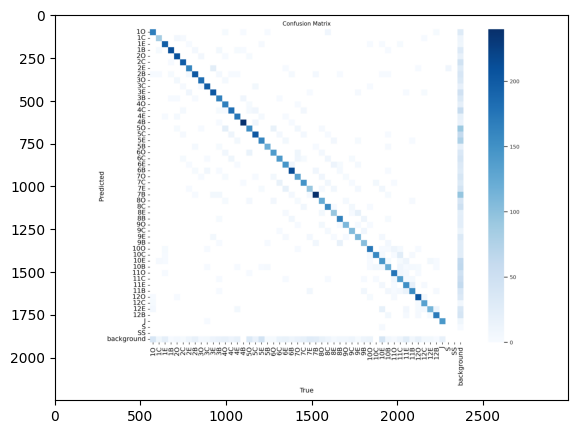

In [37]:
plt.figure(figsize=(10,5))
dist_labels = plt.imread("doc/metrics/confusion_matrix.png")
plt.imshow(dist_labels)


## Precision, F1 y Recall
---
